In [5]:
import numpy as np
import pandas as pd 

df = pd.read_csv(r'C:\Users\omarm\OneDrive\Desktop\wind-turbine-rl-Project\Dataset\Wind-Turbine-Scada-Dataset.csv')
df.head(10)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
5,01 01 2018 00:50,402.391998,5.604052,499.436385,264.578613
6,01 01 2018 01:00,447.605713,5.793008,557.372363,266.163605
7,01 01 2018 01:10,387.242188,5.306050,414.898179,257.949493
8,01 01 2018 01:20,463.651215,5.584629,493.677652,253.480698
9,01 01 2018 01:30,439.725708,5.523228,475.706783,258.723785


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [7]:
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [8]:
df.rename(columns={
    'Date/Time': 'timestamp',
    'LV ActivePower (kW)': 'active_power',
    'Wind Speed (m/s)': 'wind_speed',
    'Theoretical_Power_Curve (KWh)': 'theoretical_power',
    'Wind Direction (°)': 'wind_direction'
}, inplace=True)

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d %m %Y %H:%M')
df.set_index('timestamp', inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50530 entries, 2018-01-01 00:00:00 to 2018-12-31 23:50:00
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active_power       50530 non-null  float64
 1   wind_speed         50530 non-null  float64
 2   theoretical_power  50530 non-null  float64
 3   wind_direction     50530 non-null  float64
dtypes: float64(4)
memory usage: 1.9 MB
None


In [23]:
# Fix Negative Power Readings
# If power < 0, set to 0
df.loc[df['active_power'] < 0, 'active_power'] = 0
df['active_power'] = df['active_power'].clip(lower=0)

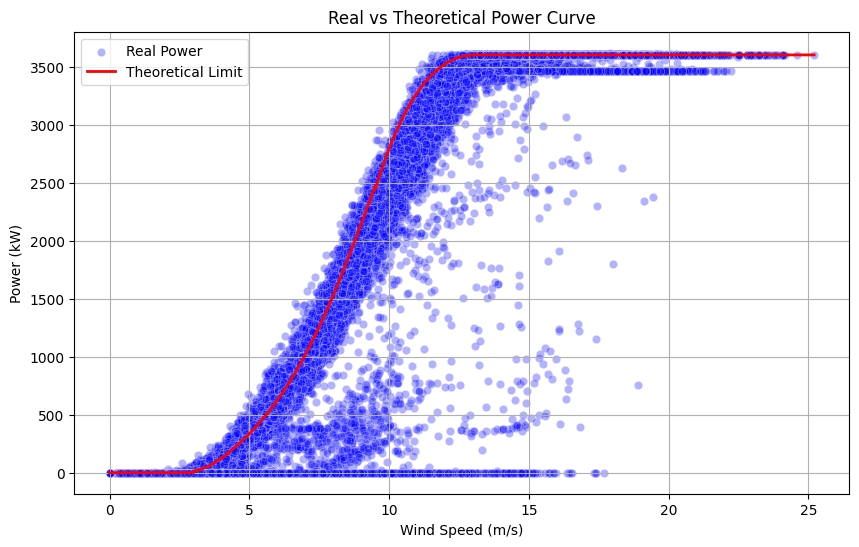

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))

# The Real Data (Blue dots)
sns.scatterplot(x=df['wind_speed'], y=df['active_power'], alpha=0.3, label='Real Power', color='blue')

# The Theoretical Curve (Red line)
# We sort by wind speed to make the line smooth
theoretical_df = df.sort_values('wind_speed')
plt.plot(theoretical_df['wind_speed'], theoretical_df['theoretical_power'], color='red', label='Theoretical Limit', linewidth=2)
plt.title("Real vs Theoretical Power Curve")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power (kW)")
plt.legend()
plt.grid(True)
plt.show()

The Physics Contradiction: Look at Wind Speed = 15 m/s.

The Red Line (Theory) says power should be ~3500 kW.

The Blue Dots (Reality) at the bottom say power is 0 kW.

What this means: The turbine was likely broken, undergoing maintenance, or manually turned off during these times.

Why this destroys RL: If you feed this data to your AI, it will get confused. It will see Wind = 15 and think: "Sometimes I generate 3500kW, and sometimes I generate 0kW. I guess physics is random."

In [26]:
# Logic: If Wind > 3.5 m/s ( Theoritical Cut-in speed) AND Power is 0, the sensor/turbine is broken.
condition = (df['wind_speed'] > 3.5) & (df['active_power'] == 0)

print(f"Dropping {condition.sum()} faulty rows.")
df_clean = df[~condition].copy()

Dropping 2220 faulty rows.


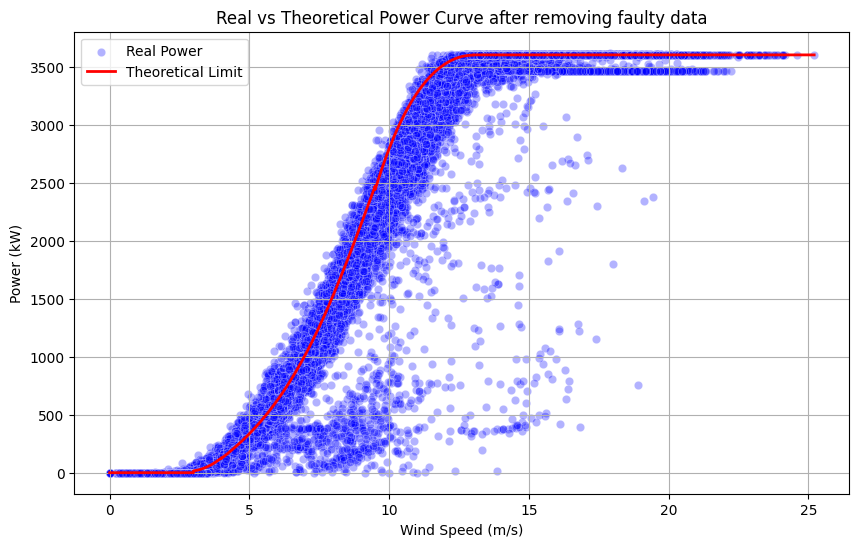

In [29]:
plt.figure(figsize=(10, 6))

# The Real Data (Blue dots)
sns.scatterplot(x=df_clean['wind_speed'], y=df_clean['active_power'], alpha=0.3, label='Real Power', color='blue')

# The Theoretical Curve (Red line)
# We sort by wind speed to make the line smooth
theoretical_df = df_clean.sort_values('wind_speed')
plt.plot(theoretical_df['wind_speed'], theoretical_df['theoretical_power'], color='red', label='Theoretical Limit', linewidth=2)

plt.title("Real vs Theoretical Power Curve after removing faulty data")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power (kW)")
plt.legend()
plt.grid(True)
plt.show()

- Cleaned sensor faults and curtailment events to ensure the RL agent learns valid aerodynamic physics.

In [31]:
# Convert timestamp to datetime object
df_clean['timestamp'] = pd.to_datetime(df_clean.index)

# Create "Hour of Day" feature (0 to 23)
hour = df_clean['timestamp'].dt.hour
df_clean['day_cycle_sin'] = np.sin(2 * np.pi * hour / 24)
df_clean['day_cycle_cos'] = np.cos(2 * np.pi * hour / 24)
df_clean.drop(columns=['timestamp'], inplace=True)

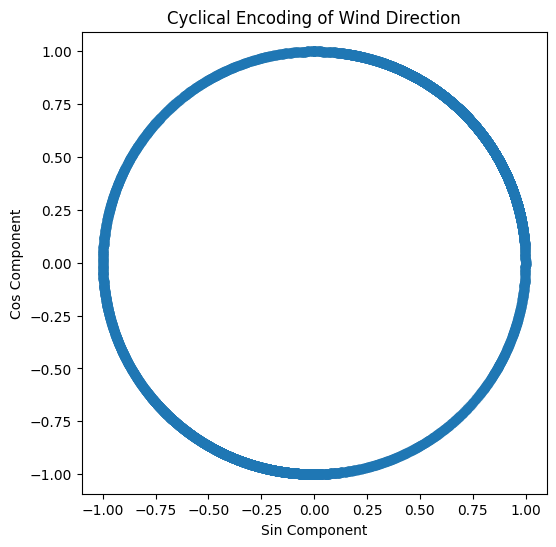

In [32]:
df_clean['wind_sin'] = np.sin(2 * np.pi * df_clean['wind_direction'] / 360)
df_clean['wind_cos'] = np.cos(2 * np.pi * df_clean['wind_direction'] / 360)

plt.figure(figsize=(6,6))
plt.scatter(df_clean['wind_sin'], df_clean['wind_cos'], alpha=0.1)
plt.title("Cyclical Encoding of Wind Direction")
plt.xlabel("Sin Component")
plt.ylabel("Cos Component")
plt.axis('equal')
plt.show()

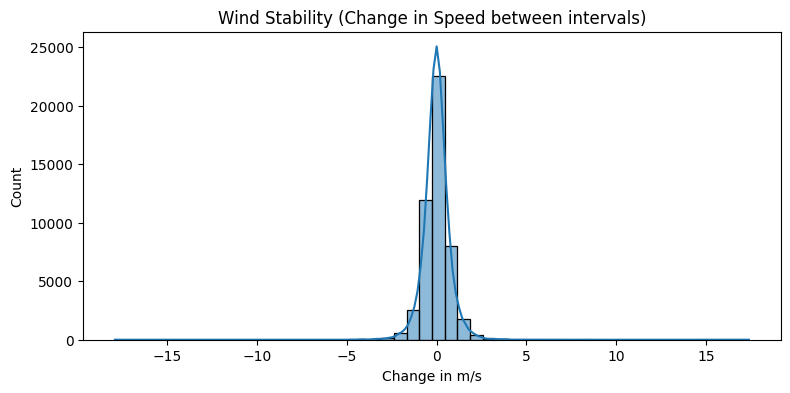

In [36]:
import warnings
warnings.filterwarnings('ignore')
df_clean['wind_diff'] = df_clean['wind_speed'].diff()
df_clean['wind_diff'].fillna(0, inplace=True)

# Plotting the distribution of wind changes
plt.figure(figsize=(9, 4))
sns.histplot(df_clean['wind_diff'], bins=50, kde=True)
plt.title("Wind Stability (Change in Speed between intervals)")
plt.xlabel("Change in m/s")
plt.show()

In [37]:
print("Max Wind:", df_clean['wind_speed'].max()) 
print("Max Power:", df_clean['active_power'].max())

Max Wind: 25.2060108184814
Max Power: 3618.73291015625


In [38]:
df_clean.head(10)

,active_power,wind_speed,theoretical_power,wind_direction,day_cycle_sin,day_cycle_cos,wind_sin,wind_cos,wind_diff
timestamp,,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0.000000,1.000000,-0.984792,-0.173736,0.000000
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0.000000,1.000000,-0.999719,-0.023715,0.360831
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0.000000,1.000000,-0.998998,0.044749,-0.456130
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0.000000,1.000000,-0.999759,0.021956,0.443637
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0.000000,1.000000,-0.997151,-0.075426,-0.081733
2018-01-01 00:50:00,402.391998,5.604052,499.436385,264.578613,0.000000,1.000000,-0.995527,-0.094480,0.026111
2018-01-01 01:00:00,447.605713,5.793008,557.372363,266.163605,0.258819,0.965926,-0.997759,-0.066908,0.188956
2018-01-01 01:10:00,387.242188,5.306050,414.898179,257.949493,0.258819,0.965926,-0.977964,-0.208774,-0.486958
2018-01-01 01:20:00,463.651215,5.584629,493.677652,253.480698,0.258819,0.965926,-0.958724,-0.284338,0.278579


In [39]:
df_clean.columns

Index(['active_power', 'wind_speed', 'theoretical_power', 'wind_direction',
       'day_cycle_sin', 'day_cycle_cos', 'wind_sin', 'wind_cos', 'wind_diff'],
      dtype='object')

In [40]:
env_data = df_clean[['wind_speed', 'wind_sin', 'wind_cos', 'theoretical_power']]
env_data.to_csv(r'C:\Users\omarm\OneDrive\Desktop\wind-turbine-rl-Project\Data\sim_weather_clean.csv', index=False)
print(" Environment Simulation data saved successfully!")

 Environment Simulation data saved successfully!
